----

In [28]:
!pip install fastai --upgrade
!pip install timm

In [29]:
import torch
from fastai.vision.all import *
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from urllib.request import urlopen
from PIL import Image
import timm
from sklearn.model_selection import train_test_split

In [30]:
# Define paths
x = '/kaggle/input/realwaste1/realwaste-main/RealWaste'
path = Path(x)
path.ls()

(#9) [Path('/kaggle/input/realwaste1/realwaste-main/RealWaste/Metal'),Path('/kaggle/input/realwaste1/realwaste-main/RealWaste/Glass'),Path('/kaggle/input/realwaste1/realwaste-main/RealWaste/Paper'),Path('/kaggle/input/realwaste1/realwaste-main/RealWaste/Vegetation'),Path('/kaggle/input/realwaste1/realwaste-main/RealWaste/Cardboard'),Path('/kaggle/input/realwaste1/realwaste-main/RealWaste/Textile Trash'),Path('/kaggle/input/realwaste1/realwaste-main/RealWaste/Food Organics'),Path('/kaggle/input/realwaste1/realwaste-main/RealWaste/Plastic'),Path('/kaggle/input/realwaste1/realwaste-main/RealWaste/Miscellaneous Trash')]

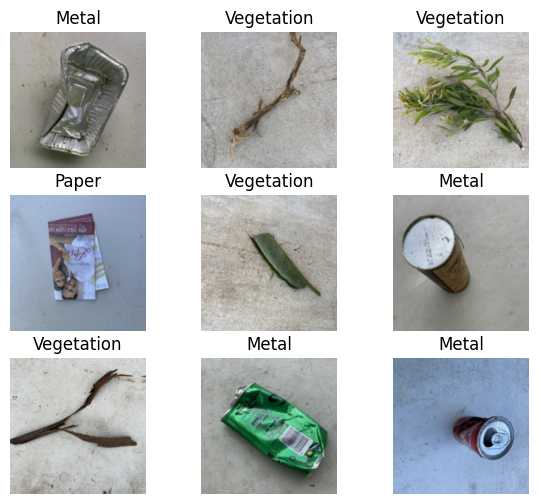

In [31]:
np.random.seed(40)
# Define the DataBlock
data = ImageDataLoaders.from_folder(path, train='.', valid_pct=0.2,
                                    item_tfms=Resize(224),  # Adjusted size for DINO
                                    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)],
                                    num_workers=4)

# Show a batch of images
data.show_batch(figsize=(7,6))

In [32]:
data

In [33]:
# Load the pre-trained DINO model using timm
vitb16 = timm.create_model('vit_base_patch16_224.dino', pretrained=True)
vitb16.head = nn.Identity()  

In [34]:
# Define a custom head to attach to the DINO model
class DinoHead(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.head = nn.Linear(vitb16.num_features, num_classes)
        
    def forward(self, x):
        x = vitb16(x)
        x = self.head(x)
        return x

# Create the learner with the custom model
learn = Learner(data, DinoHead(len(data.vocab)), metrics=accuracy, model_dir=Path('/kaggle/working/'))
learn.model.vitb16 = vitb16

In [35]:
#print(f"Suggested Learning Rate: {learn.recorder.lr_find()}")
# Plot learning rate
#learn.recorder.plot_lr_find()

In [36]:
lr1 = 1e-5
lr2 = 1e-4
learn.fit_one_cycle(40, slice(lr1, lr2))

epoch,train_loss,valid_loss,accuracy,time
0,1.334599,0.799077,0.721053,01:17
1,0.699261,0.381618,0.876842,01:17
2,0.361480,0.234012,0.928421,01:17
3,0.180978,0.215274,0.918947,01:17
4,0.116653,0.248497,0.916842,01:17
5,0.117454,0.330382,0.894737,01:17
6,0.133842,0.307617,0.913684,01:17
7,0.144209,0.375061,0.903158,01:16
8,0.122956,0.364673,0.913684,01:17
9,0.128163,0.396189,0.905263,01:17


In [37]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-6, lr1))

epoch,train_loss,valid_loss,accuracy,time
0,0.000064,0.303691,0.949474,01:17
1,0.000060,0.303262,0.950526,01:17
2,0.000282,0.288540,0.949474,01:17
3,0.000121,0.288897,0.949474,01:17
4,0.000073,0.290938,0.951579,01:17
5,0.000048,0.295133,0.949474,01:17
6,0.000044,0.291256,0.950526,01:17
7,0.000039,0.291607,0.951579,01:17
8,0.000024,0.290789,0.951579,01:17
9,0.000019,0.290548,0.951579,01:17


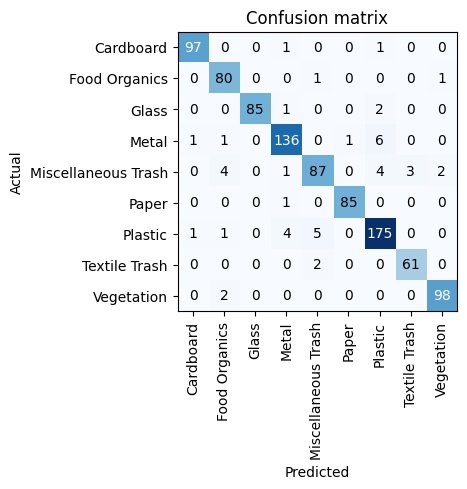

In [38]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

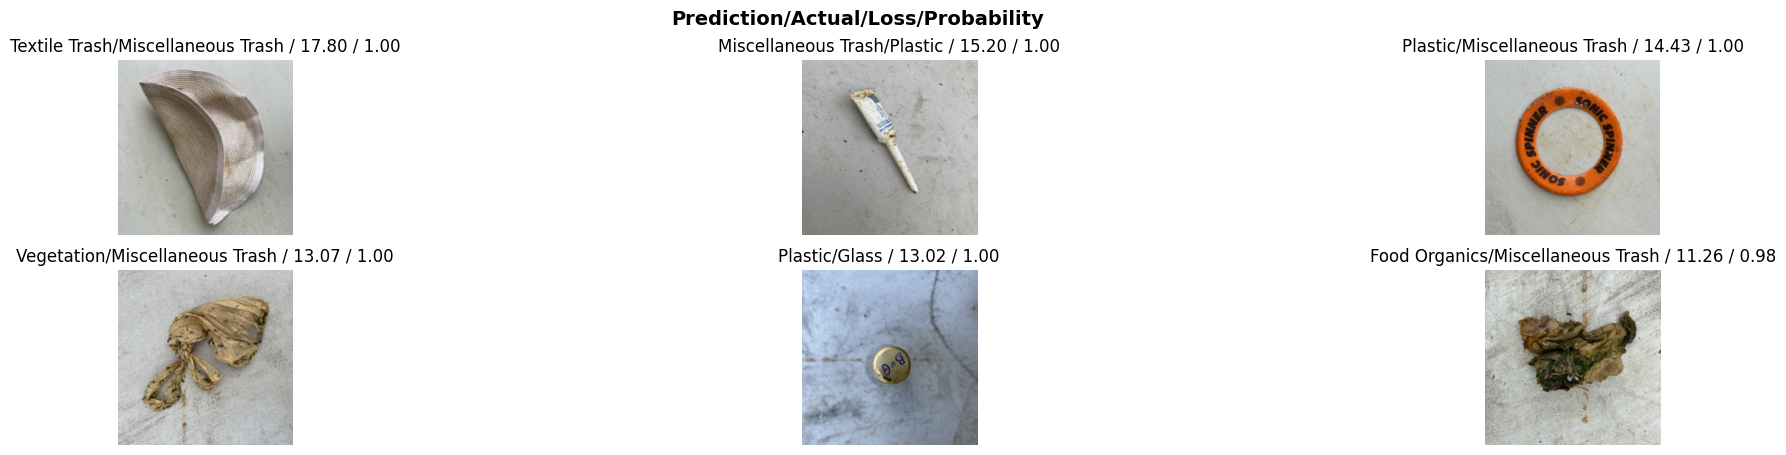

In [39]:
interp.plot_top_losses(6,figsize = (25,5))

In [40]:
# Export the model
learn.export("/kaggle/working/export.pkl")
learn.model_dir = "/kaggle/working"
learn.save("dino-final")

Path('/kaggle/working/dino-final.pth')

In [41]:
# Evaluate the model on the validation set
val_loss, val_acc = learn.validate()

print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_acc:.4f}')

Validation Loss: 0.2885
Validation Accuracy: 0.9516


In [42]:
# Define the mapping for recyclable and non-recyclable labels
recyclable_labels = ['Metal', 'Plastic', 'Glass', 'Paper', 'Cardboard']

# Function to map predicted classes to recyclable and non-recyclable
def map_to_recyclable(prediction):
    return 'Recyclable' if prediction in recyclable_labels else 'Non-Recyclable'

# Get predictions for the validation set
preds, y_true = learn.get_preds(ds_idx=1)
preds_classes = np.argmax(preds, axis=1)
preds_labels = [learn.dls.vocab[pred] for pred in preds_classes]

# Map predictions to recyclable and non-recyclable
mapped_preds = [map_to_recyclable(label) for label in preds_labels]

# Map true labels to recyclable and non-recyclable
y_true_labels = [learn.dls.vocab[label] for label in y_true]
mapped_true = [map_to_recyclable(label) for label in y_true_labels]

# Calculate accuracy
accuracy = np.mean([pred == true for pred, true in zip(mapped_preds, mapped_true)])

print(f'Validation Accuracy (Recyclable vs Non-Recyclable): {accuracy:.4f}')

Validation Accuracy (Recyclable vs Non-Recyclable): 0.9874


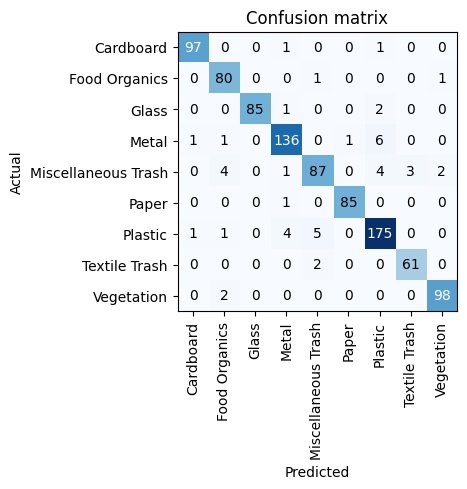

In [43]:
interp.plot_confusion_matrix()
plt.savefig('confusion_matrix.png')

<a href="#top" class="btn btn-success btn-lg active" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go to TOP</a>